In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn import preprocessing
from datetime import datetime
from scipy import stats
from sklearn.decomposition import PCA

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.3f}'.format

In [17]:
# 1- read processed file
file_dir = '../data/processed-data/'
data_file = 'normalized_dataset.csv'

normalized_data = pd.read_csv(file_dir + data_file)
normalized_data.shape

(1584, 12)

In [18]:
normalized_data.describe()

,ltcy,svc_cpu_use,svc_cpu_thr,svc_net_use,svc_disk_use,system_cpu_use,system_cpu_sat,system_net_use,svc_req_size,svc_resp_size,svc_pods,svc_req_rate
count,"1,584.000","1,584.000","1,584.000","1,584.000","1,584.000","1,584.000","1,584.000","1,584.000","1,584.000","1,584.000","1,584.000","1,584.000"
mean,0.777,1.256,0.623,0.828,0.225,"4,759.075",17.579,14.493,0.023,0.158,13.646,19.221
std,0.191,0.292,0.255,0.232,0.083,"3,018.836",11.862,5.392,0.012,0.113,4.475,9.134
min,0.332,0.332,0.000,0.190,0.000,14.165,0.699,2.864,0.000,0.001,2.000,0.200
25%,0.648,1.068,0.436,0.659,0.165,"2,060.612",6.428,10.329,0.014,0.038,10.000,11.775
50%,0.794,1.288,0.632,0.841,0.224,"4,814.819",17.424,15.167,0.023,0.163,14.000,20.470
75%,0.927,1.473,0.794,1.017,0.283,"7,545.077",26.365,18.156,0.031,0.254,18.000,25.980
max,1.217,1.822,1.245,1.290,0.440,"9,683.820",51.619,24.698,0.055,0.382,21.000,35.110


# Multicollinearity

Use Variance Inflation Factor (VIF) from the statmodels. VIF measures how big is the square root of the standard error is compared to the case there is no multicollinearity between the variables. 
Conventionally:

$VIF = 1$ means no multicollinearity

$1< VIF < 5$ perfectly okay

$10 < VIF$ unacceptable range (some times < 6 or 8)

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = normalized_data[['svc_cpu_use'
            ,'svc_cpu_thr'
            ,'svc_net_use'
            ,'svc_disk_use'
            ,'system_cpu_use'
            ,'system_cpu_sat'
            ,'system_net_use'
            ,'svc_req_size'
            ,'svc_resp_size'
            ,'svc_pods']]
vif = pd.DataFrame()
vif['features'] = variables.columns
vif['VIF'] = [variance_inflation_factor(variables.values,i) for i in range(variables.shape[1])]
vif

,features,VIF
0,svc_cpu_use,32.969
1,svc_cpu_thr,10.759
2,svc_net_use,29.844
3,svc_disk_use,14.469
4,system_cpu_use,11.120
5,system_cpu_sat,7.730
6,system_net_use,72.605
7,svc_req_size,16.373
8,svc_resp_size,4.755
9,svc_pods,10.987


vif values are high. Consider using PCA or apply feature selection method to reduce dimentionality when using a ML model.

# Correlation Matrix

In [20]:
corr = normalized_data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,ltcy,svc_cpu_use,svc_cpu_thr,svc_net_use,svc_disk_use,system_cpu_use,system_cpu_sat,system_net_use,svc_req_size,svc_resp_size,svc_pods,svc_req_rate
ltcy,1.000,0.389,0.421,0.413,0.390,0.381,0.390,0.532,0.497,0.363,0.022,0.562
svc_cpu_use,0.389,1.000,0.398,0.604,0.545,0.559,0.504,0.748,0.670,0.472,0.285,0.744
svc_cpu_thr,0.421,0.398,1.000,0.454,0.381,0.156,0.238,0.490,0.486,0.322,-0.062,0.510
svc_net_use,0.413,0.604,0.454,1.000,0.527,0.506,0.479,0.752,0.676,0.492,0.257,0.749
svc_disk_use,0.390,0.545,0.381,0.527,1.000,0.452,0.409,0.648,0.589,0.423,0.188,0.654
system_cpu_use,0.381,0.559,0.156,0.506,0.452,1.000,0.730,0.739,0.589,0.418,0.429,0.731
system_cpu_sat,0.390,0.504,0.238,0.479,0.409,0.730,1.000,0.689,0.553,0.396,0.280,0.689
system_net_use,0.532,0.748,0.490,0.752,0.648,0.739,0.689,1.000,0.848,0.616,0.352,0.985
svc_req_size,0.497,0.670,0.486,0.676,0.589,0.589,0.553,0.848,1.000,0.540,0.247,0.855
svc_resp_size,0.363,0.472,0.322,0.492,0.423,0.418,0.396,0.616,0.540,1.000,0.198,0.620


In [21]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
#plot_corr(normalized_data,20)    

The function most_highly_correlated() will print out the linear correlation coefficients for each pair of variables in your data set, in order of the correlation coefficient. This lets you see very easily which pair of variables are most highly correlated.

In [22]:
def most_highly_correlated(mydataframe, numtoreport):
    # find the correlations
    cormatrix = mydataframe.corr()
    # set the correlations on the diagonal or lower triangle to zero,
    # so they will not be reported as the highest ones:
    cormatrix *= np.tri(*cormatrix.values.shape, k=-1).T
    # find the top n correlations
    cormatrix = cormatrix.stack()
    cormatrix = cormatrix.reindex(cormatrix.abs().sort_values(ascending=False).index).reset_index()
    # assign human-friendly names
    cormatrix.columns = ["FirstVariable", "SecondVariable", "Correlation"]
    return cormatrix.head(numtoreport)

mcdf = most_highly_correlated(normalized_data, 30)
mcdf = mcdf[mcdf.Correlation > 0.5]

mcdf

,FirstVariable,SecondVariable,Correlation
0,system_net_use,svc_req_rate,0.985
1,svc_req_size,svc_req_rate,0.855
2,system_net_use,svc_req_size,0.848
3,svc_net_use,system_net_use,0.752
4,svc_net_use,svc_req_rate,0.749
...,...,...,...
25,svc_req_size,svc_resp_size,0.540
26,ltcy,system_net_use,0.532
27,svc_net_use,svc_disk_use,0.527
28,svc_cpu_thr,svc_req_rate,0.510


# Features Selection

## 1- SelectFromModel Meta-Transformer
sklearn doc: https://scikit-learn.org/stable/modules/feature_selection.html

example with regression case: https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_boston.html


In [34]:
# using SelectFromModel metatransformer to select features
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

targets = normalized_data['ltcy']
inputs = normalized_data.drop(['ltcy'], axis=1)

print('shape of inputs %', inputs.shape)

clf = LassoCV(normalize=False, random_state=365, cv=10, verbose=0) # normalize=False because data already scaled 

scaler = StandardScaler()
scaler.fit(inputs)
standarized_inputs = scaler.transform(inputs)

print('shape of standardized inputs %', standarized_inputs.shape)

sfm = SelectFromModel(clf, threshold=0.05)  
sfm.fit(standarized_inputs, targets)

transformed_inputs = sfm.transform(inputs)

print('shape of transformed inputs %', transformed_inputs.shape)

transformed_inputs


shape of inputs % (1584, 11)
shape of standardized inputs % (1584, 11)
shape of transformed inputs % (1584, 1)


array([[ 0.98],
       [ 1.62],
       [ 2.18],
       ...,
       [33.91],
       [33.31],
       [33.91]])

## 2- Component Analysis (PCA)

Check adquacy of the correlation matrix for factor analysis. Checking both Bartlett's test if the correlation matrix is collectively significant to include factors, and checking the Measure of Adquacy Samplin (MSA), a.k.a Kaiser-Meyer-Olkin (KMO) to check the pattern

In [24]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

# Bartlett ’s test
chi_square_value,p_value=calculate_bartlett_sphericity(normalized_data)

chi_square_value, p_value

(16725.102119495536, 0.0)

In this Bartlett’s test, the p-value is 0. The test was statistically significant, indicating that the observed correlation matrix is not an identity matrix.

In [25]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all,kmo_model=calculate_kmo(normalized_data)

kmo_model

0.9246254685709241

The overall KMO for our data is 0.93, which is excellent ( > 0.5). This value indicates that you can proceed with your planned factor analysis.

In [26]:
kmo_all

array([0.95777426, 0.98886838, 0.91764973, 0.98782432, 0.99028234,
       0.91001632, 0.93866453, 0.85464858, 0.98699042, 0.99238765,
       0.75408302, 0.84834168])

Features KMO values are significant ( > 0.5). It would be ok to consider them all to analyze the factors.

You can get a summary of the principal component analysis results using the pca_summary() function below, which simulates the output of R’s summary function on a PCA model:

In [27]:
def pca_summary(pca, standardised_data, out=True):
    names = ["PC"+str(i) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    a = list(np.std(pca.transform(standardised_data), axis=0))
    b = list(pca.explained_variance_ratio_)
    c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    columns = pd.MultiIndex.from_tuples([("sdev", "Standard deviation"), ("varprop", "Proportion of Variance"), ("cumprop", "Cumulative Proportion")])
    summary = pd.DataFrame(zip(a, b, c), index=names, columns=columns)
    if out:
        print("Importance of components:")
        display(summary)
    return summary

# Make an instance of the Model
#pca = PCA(n_components=2, svd_solver = 'arpack', random_state=365)
pca = PCA(n_components=0.8)   # at least to explain 80% of cumulative propotion of variance
pca.fit(standarized_inputs)  

summary = pca_summary(pca, standarized_inputs)


Importance of components:


,sdev,varprop,cumprop
,Standard deviation,Proportion of Variance,Cumulative Proportion
PC1,2.530,0.582,0.582
PC2,1.114,0.113,0.694
PC3,0.832,0.063,0.757
PC4,0.779,0.055,0.812


In order to decide how many principal components should be retained, it is common to summarise the results of a principal components analysis by making a scree plot, which we can do using the screeplot() function below. Notice the Y value of the graph (Variance) when the curve elbow shows.

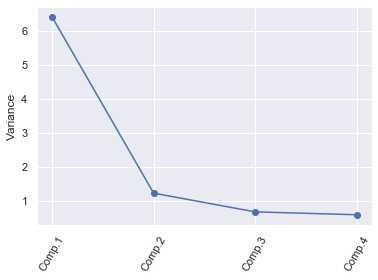

In [28]:
def screeplot(pca, standardised_values):
    y = np.std(pca.transform(standardised_values), axis=0)**2
    x = np.arange(len(y)) + 1
    plt.plot(x, y, "o-")
    plt.xticks(x, ["Comp."+str(i) for i in x], rotation=60)
    plt.ylabel("Variance")
    plt.show()

screeplot(pca, standarized_inputs)

The most obvious change in slope in the scree plot occurs at component 3, which is the “elbow” of the scree plot. Therefore, it cound be argued based on the basis of the scree plot that at least 2 components (on top of y value variance = 1 in the diagram above) should be retained 

Now we can find out the loadings of all features into the principal components

## PCA Loadings

In [29]:
variables = inputs.columns.values
loadings = pd.DataFrame(pca.components_, columns=variables)
loadings

,svc_cpu_use,svc_cpu_thr,svc_net_use,svc_disk_use,system_cpu_use,system_cpu_sat,system_net_use,svc_req_size,svc_resp_size,svc_pods,svc_req_rate
0,-0.317,-0.207,-0.315,-0.280,-0.305,-0.289,-0.382,-0.345,-0.263,-0.150,-0.382
1,0.029,0.585,0.119,0.143,-0.382,-0.256,-0.001,0.112,0.086,-0.624,0.040
2,-0.100,-0.129,-0.173,-0.138,0.332,0.578,0.031,-0.012,-0.206,-0.657,0.074
3,0.132,0.304,0.079,0.162,0.034,0.030,0.009,0.038,-0.904,0.192,-0.004


To calculate the values of a principal component, we can define our own function to calculate a principal component given the loadings and the input variables’ values:

In [30]:
def calcpc(variables, loadings):
    # find the number of samples in the data set and the number of variables
    numsamples, numvariables = variables.shape
    # make a vector to store the component
    pc = np.zeros(numsamples)
    # calculate the value of the component for each sample
    for i in range(numsamples):
        valuei = 0
        for j in range(numvariables):
            valueij = variables.iloc[i, j]
            loadingj = loadings[j]
            valuei = valuei + (valueij * loadingj)
        pc[i] = valuei
    return pc

# considering the first 2 factors
pc1_data = calcpc(pd.DataFrame(standarized_inputs), pca.components_[0])
pc1_data = pd.DataFrame(pc1_data, columns=['factor1'])

pc2_data = calcpc(pd.DataFrame(standarized_inputs), pca.components_[1])
pc2_data = pd.DataFrame(pc2_data,  columns=['factor2'])

pc3_data = calcpc(pd.DataFrame(standarized_inputs), pca.components_[2])
pc3_data = pd.DataFrame(pc3_data,  columns=['factor3'])

pc4_data = calcpc(pd.DataFrame(standarized_inputs), pca.components_[3])
pc4_data = pd.DataFrame(pc4_data,  columns=['factor4'])

factor_data = pd.concat([pc1_data, pc2_data, pc3_data, pc4_data, targets], axis=1, sort=False)
factor_data.head(5)

,factor1,factor2,factor3,factor4,ltcy
0,5.907,0.168,0.822,-0.491,0.332
1,5.703,0.148,0.776,-0.524,0.400
2,5.657,0.195,0.760,-0.562,0.469
3,5.464,0.406,0.815,-0.469,0.490
4,5.461,0.907,1.210,-0.537,0.500


# Save the Component Factors Dataset

In [31]:
if 1 == 0:
    factor_data.to_csv(path_or_buf=file_dir + 'factored_dataset.csv', index=False)

# Scale the features and save to a file

In [32]:
from sklearn.preprocessing import StandardScaler

targets = normalized_data['ltcy']
inputs = normalized_data.drop(['ltcy'], axis=1)

variables = inputs.columns.values

print('shape of inputs %', inputs.shape)

scaler = StandardScaler()
scaler.fit(inputs)
standarized_inputs = scaler.transform(inputs)
standarized_inputs = pd.DataFrame(standarized_inputs, columns=variables)

scaled_data = pd.concat([standarized_inputs,targets], axis=1, sort=False)

if 1 == 1:
     scaled_data.to_csv(path_or_buf=file_dir + 'standardized_normalized_dataset.csv', index=False)
    



shape of inputs % (1584, 11)
